In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from pymc3.distributions.dist_math import bound

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
# simulate data from a known mixture distribution
np.random.seed(12345)  # set random seed for reproducibility

k = 2
ndata = 2500
# spread = 5
# centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
b_intercept_1 = -1
b_intercept_2 = 1

b_1_1 = 0.2
b_1_2 = 1

x = np.random.normal(loc = 1, scale = 1, size = ndata)
data = np.empty(ndata)
for i in range(ndata):
    if i < ndata/2:
        new = np.random.poisson(lam = np.exp(b_intercept_1 + b_1_1*x[i]), size = 1)
    else:
        new = np.random.poisson(lam = np.exp(b_intercept_2 + b_1_2*x[i]), size = 1)
    
    data[i] = new

In [4]:
data

array([ 1.,  0.,  0., ...,  6., 32., 23.])

(array([2.23e+03, 1.91e+02, 4.30e+01, 2.10e+01, 6.00e+00, 4.00e+00,
        3.00e+00, 0.00e+00, 1.00e+00, 1.00e+00]),
 array([  0. ,  17.9,  35.8,  53.7,  71.6,  89.5, 107.4, 125.3, 143.2,
        161.1, 179. ]),
 <BarContainer object of 10 artists>)

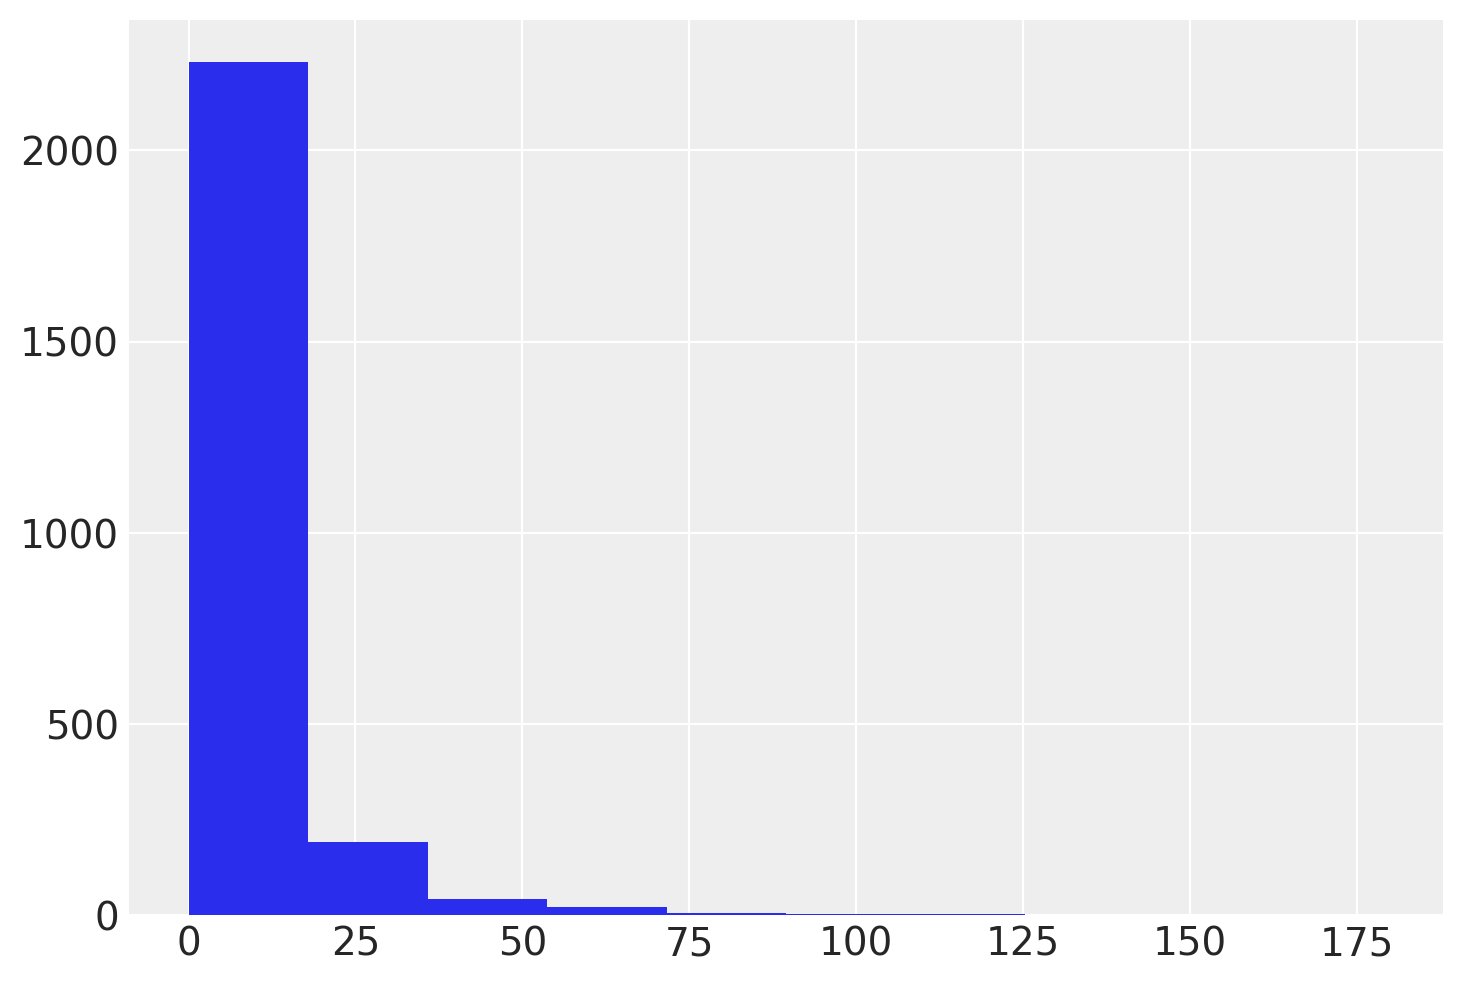

In [5]:
plt.hist(data)

In [6]:
df = pd.DataFrame({'intercepto':[1]*ndata, 'y': data, 'x': x})

In [7]:
df

,intercepto,y,x
0,1,1.0,0.795292
1,1,0.0,1.478943
2,1,0.0,0.480561
3,1,1.0,0.444270
4,1,0.0,2.965781
...,...,...,...
2495,1,3.0,0.680048
2496,1,3.0,0.183701
2497,1,6.0,0.400177
2498,1,32.0,2.472026


In [8]:
# setup model
model = pm.Model()
with model:
    
    #mixture components
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=k)
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))
    

    # define priors, weakly informative Normal
    b01 = pm.Normal("b1_intercept", mu=0, sigma=10)
    b11 = pm.Normal("b1_1", mu=0, sigma=10)
    b02 = pm.Normal("b2_intercept", mu=0, sigma=10)
    b12 = pm.Normal("b1_2", mu=0, sigma=10)

    # define linear model and exp link function
    theta_1 = (
        b01
        + b11 * df['x']
    )
    
    theta_2 = (
        b02
        + b12 * df['x']
    )

    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(np.exp(theta_1) - np.exp(theta_2) < 0, -np.inf, 0))
    
    ## Define Poisson likelihood
    poisson1 = pm.Poisson.dist(mu = np.exp(theta_1))
    poisson2 = pm.Poisson.dist(mu = np.exp(theta_2))
    
    like = pm.Mixture('like', w=p, comp_dists = [poisson1, poisson2], observed=df["y"].values)

In [9]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, b01, b11, b02, b12])
    tr = pm.sample(10000, step=[step1], tune=5000)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [b1_2]
>Metropolis: [b2_intercept]
>Metropolis: [b1_1]
>Metropolis: [b1_intercept]
>Metropolis: [p]


/usr/local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 71 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'b1_intercept'}>,
        <AxesSubplot:title={'center':'b1_intercept'}>],
       [<AxesSubplot:title={'center':'b1_1'}>,
        <AxesSubplot:title={'center':'b1_1'}>],
       [<AxesSubplot:title={'center':'b2_intercept'}>,
        <AxesSubplot:title={'center':'b2_intercept'}>],
       [<AxesSubplot:title={'center':'b1_2'}>,
        <AxesSubplot:title={'center':'b1_2'}>]], dtype=object)

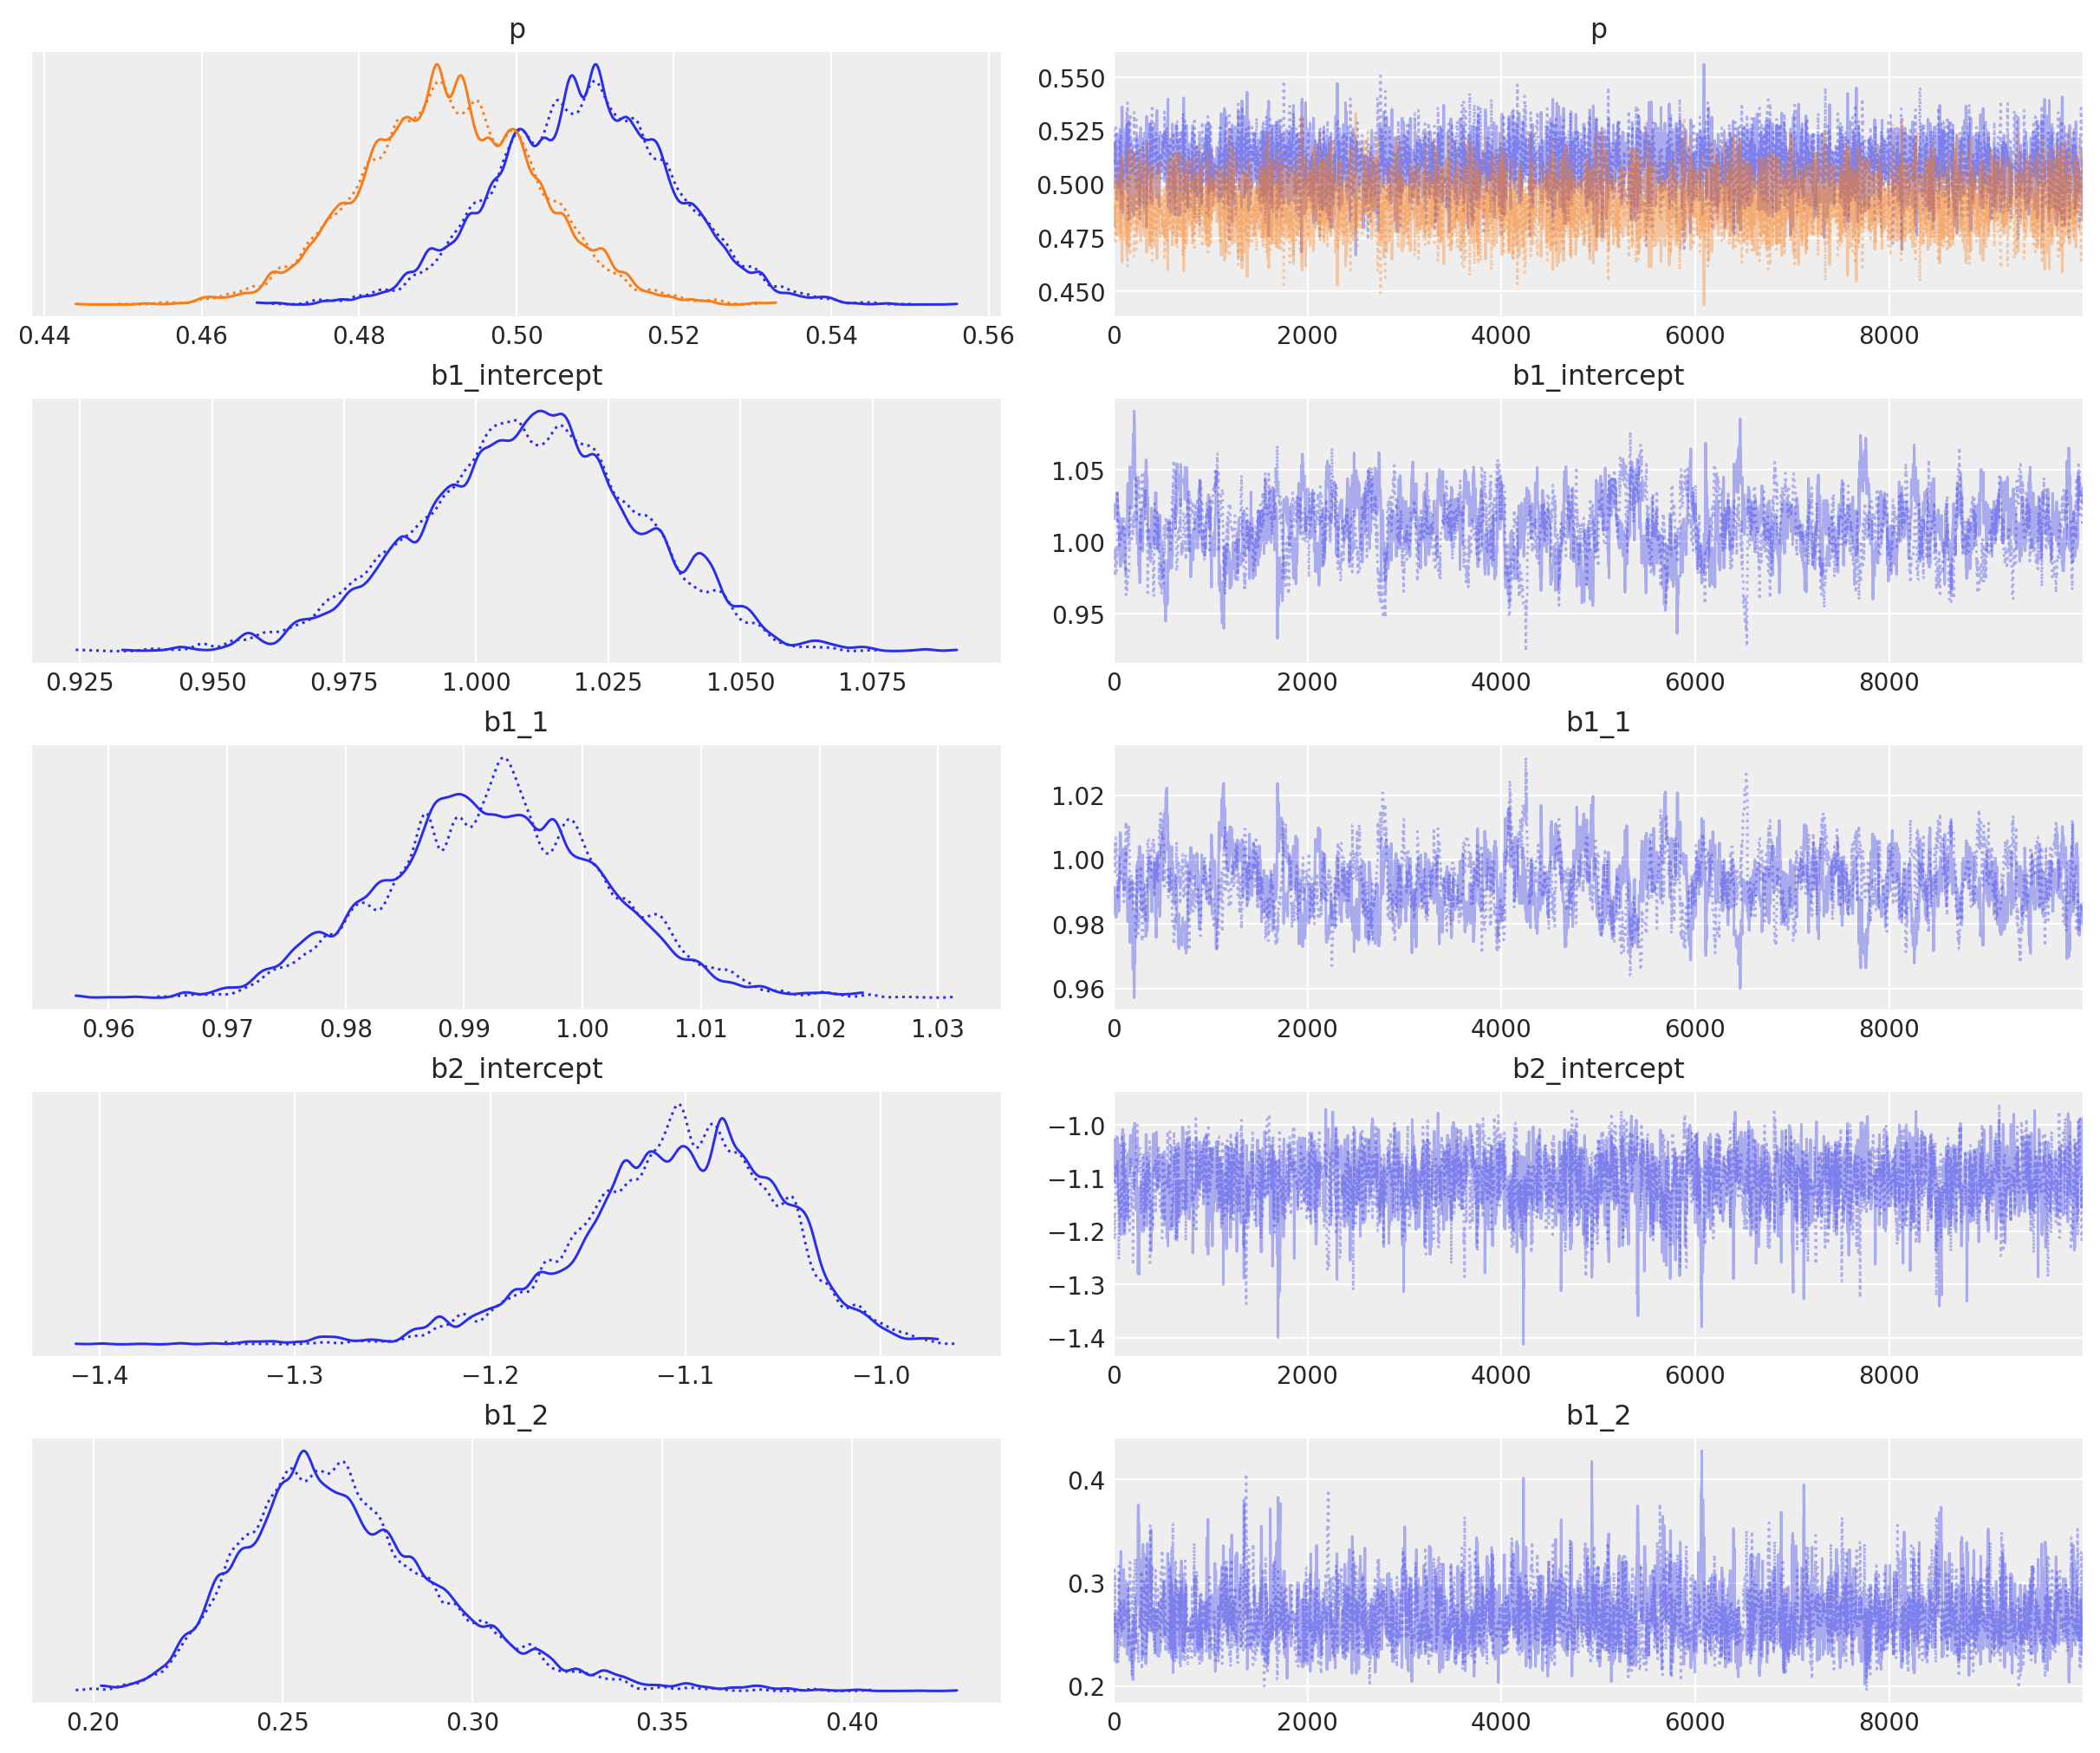

In [10]:
pm.traceplot(tr, var_names=["p", "b1_intercept", "b1_1", "b2_intercept", "b1_2"])

In [11]:
pm.summary(tr, var_names=["p", "b1_intercept", "b1_1", "b2_intercept", "b1_2"])

/usr/local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.509,0.011,0.488,0.530,0.000,0.000,2344.0,3857.0,1.0
p[1],0.491,0.011,0.470,0.512,0.000,0.000,2344.0,3857.0,1.0
b1_intercept,1.010,0.021,0.970,1.049,0.001,0.001,352.0,649.0,1.0
b1_1,0.993,0.009,0.975,1.009,0.001,0.000,343.0,642.0,1.0
b2_intercept,-1.105,0.052,-1.201,-1.009,0.002,0.001,1148.0,2182.0,1.0
b1_2,0.267,0.027,0.221,0.319,0.001,0.001,1281.0,2064.0,1.0
